In [755]:
import ROOT
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from pathlib import Path

[4.08120948e+01 3.32631613e+01 8.88042325e+02 1.76918092e+01
 6.26925039e+01 1.07902892e+01 1.22124839e+02 8.60730520e-01]


/tmp/ipykernel_300746/3959109890.py:19: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(1 - electron_mass * (1/energy_out - 1/energy_in))
/tmp/ipykernel_300746/3959109890.py:19: RuntimeWarning: divide by zero encountered in divide
  return np.arccos(1 - electron_mass * (1/energy_out - 1/energy_in))
/tmp/ipykernel_300746/3959109890.py:31: RuntimeWarning: divide by zero encountered in divide
  out = 1/2 * re**2 * (eOeI)**2 * (eOeI + 1/eOeI - np.sin(theta)**2)


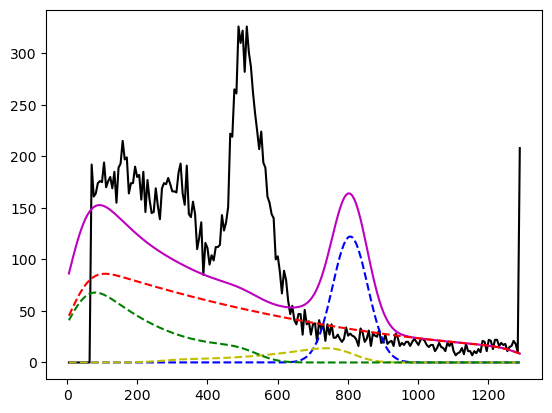

In [766]:
def bi_modal(x, a1, m1, s1, a2, m2, s2, m, c):
    return (
        a1 * np.exp(-(((x - m1) / s1) ** 2))
        + a2 * np.exp(-(((x - m2) / s2) ** 2))
        + m * x
        + c
    )

# Compton Fit & Helpers
electron_mass = 511 # keV

def gausn(x, m, s):
    return np.exp(-((x-m)/s)**2 / 2) / (s * (2*np.pi)**0.5)

def compton_energy(energy_in, theta):
    return energy_in / ( 1 + energy_in / electron_mass * (1 - np.cos(theta)))

def compton_theta(energy_in, energy_out):
    return np.arccos(1 - electron_mass * (1/energy_out - 1/energy_in))

def klein_nishina(energy_in, energy_out):
    re = 1

    energy_in = np.asarray(energy_in)
    energy_out = np.asarray(energy_out)
    minE, maxE = energy_in/(1+2*energy_in/electron_mass), energy_in
    maskE = (minE <= energy_out) & (energy_out <= maxE)

    eOeI = energy_out/energy_in
    theta = compton_theta(energy_in, energy_out)
    out = 1/2 * re**2 * (eOeI)**2 * (eOeI + 1/eOeI - np.sin(theta)**2)
    out[~maskE] = 0

    return out

def full_spectrum(x, *args):
    o, s = None, 0
    m1, a1, ac1, ae1 = 0, 0, 0, 0
    a2, ac2, ae2 = None, None, None
    c = None
    energy0 = 511 # keV, for Na22
    energy02 = 1275 # kev, for Na22 2nd photopeak

    dx = x[1] - x[0]
    x0 = x*1.
    if x[0] > 0:
        x = np.arange(x.max(), 0, -dx)[::-1]
    # pad x to x=0 (needed for conv)

    match len(args):
        case 5:
            s, m1, a1, ac1, ae1 = args
        case 6:
            # o, s, m1, a1, ac1, ae1 = args
            s, m1, a1, ac1, ae1, c = args
        case 7:
            s, m1, a1, ac1, ae1, ae2, c = args
        case 8:
            o, s, m1, a1, ac1, ae1, ae2, c = args
        #     s, m1, a1, ac1, ae1, a2, ac2, ae2 = args
        # case 9:
        #     o, s, m1, a1, ac1, ae1, a2, ac2, ae2 = args
        case _:
            raise ValueError(f"args length = {len(args)}")

    if o is not None:
        x = x - o
        # x[x<0] = 0
    # x_size = len(x)
    # x = np.append(x)

    idx_sigg = np.argmin(np.abs(x - m1))
    sigg = np.zeros_like(x)
    sigg[idx_sigg] = a1

    ex = energy0 * x/x[idx_sigg]
    sigc = ac1 * klein_nishina(energy0, ex)
    sige = ae1 * klein_nishina(energy0, energy0 - ex)

    out = sigg + sigc + sige

    if ae2 is not None and ae2 > 0:
        sige2 = ae2 * klein_nishina(energy02, energy02 - ex)
        out = out + sige2


    if s is not None and s > 0:
        x2 = np.arange(((-5*s)//dx)*dx, ((5*s)//dx + 1)*dx, dx)
        response = gausn(x2, 0, s)
        out2 = np.convolve(out, response, "same") / response.sum()
        if len(out2) > len(out):
            lo, lo2 = len(out), len(out2)
            out = out2[(lo2-lo)//2:lo2 - (lo2-lo+1)//2]
        else:
            out = out2

    if c is not None and c > 0:
        out = out + c

    if len(out) != len(x0):
        out = out[-len(x0):]

    return out

x, y = x_original, y_original
x = np.arange(x.max(), 0, -(x[1]-x[0]))[::-1]
y = np.append(np.zeros(len(x)-len(x_original)), y)
print(cparam_tuple)

# o = 200
# s, m1, a1, ac1, ae1, ae2, c = cparam_tuple
# o, s, m1, a1, ac1, ae1, ae2, c = 0, *cparam_tuple
# o, s, m1, a1, ac1, ae1, ae2, c = 0, 200, 800, 2600, 20, 100, 100, 0
o, s, m1, a1, ac1, ae1, ae2, c = 0, 50, 800, 2600, 20, 100, 100, 0
# s, m1, a1, ac1, ae1, ae2, c = 50, 760, 2600, 20, 350, 0, 30
# s, m1, a1, ac1, ae1, ae2, c = 0, 750, 250, 100, 200, 200, 30
# o, s, m1, a1, ac1, ae1, ae2, c = 0, 0, 800, 100, 100, 100, 100, 0

# m1 = m1 - o
y_spectrum = full_spectrum(x, o, s, m1, a1, ac1, ae1, ae2, c)
y_sg = full_spectrum(x, o, s, m1, a1, 0, 0, 0, 0)
y_sc = full_spectrum(x, o, s, m1, 0, ac1, 0, 0, 0)
y_se = full_spectrum(x, o, s, m1, 0, 0, ae1, 0, 0)
y_se2 = full_spectrum(x, o, s, m1, 0, 0, 0, ae2, 0)
plt.plot(x, y, "k")
plt.plot(x, y_spectrum, "m")
plt.plot(x, y_sg, "b--")
plt.plot(x, y_sc, "y--")
plt.plot(x, y_se, "g--")
plt.plot(x, y_se2, "r--")

In [757]:
def find_main_peak(hist, move_param):
    for i in range(3):
        if i == 0:
            # bin = 0;       underflow bin
            # bin = 1;       first bin with low-edge xlow INCLUDED
            # bin = nbins;   last bin with upper-edge xup EXCLUDED
            # bin = nbins+1; overflow bin
            centers = np.array([hist.GetBinCenter(ibin) for ibin in range(1, hist.GetNbinsX())])
            content = np.array([hist.GetBinContent(ibin) for ibin in range(1, hist.GetNbinsX())])
            A, mu = 0, 0
            for ic, (ce, co) in enumerate(zip(centers[::-1], content[::-1])):
                if ic < 10:
                    continue
                # co_ave10, ce_ave10 = np.mean(content[::-1][ic-5:ic+5]), np.mean(centers[::-1][ic-5:ic+5])
                # co_ave10, ce_ave10 = np.mean(content[::-1][ic-10:ic+10]), np.mean(centers[::-1][ic-10:ic+10])
                # if co_ave10 > A and co_ave10 > np.mean(content):
                #     mu, A = ce_ave10, co_ave10
                # if mu and co_ave10 < A*3/4:
                #     break
                left = np.mean(content[::-1][ic:ic+move_param])
                right = np.mean(content[::-1][ic-move_param:ic])
                center = np.mean(content[::-1][ic-5:ic+5])
                if center > left and center > right and center > np.mean(content) and abs(left-right)*2/(left+right) < 0.1:# and center > A:
                    mu, A = ce, co
                    # print(hist.GetName(), mu, A)
                    return mu, A
        return 0,0

In [758]:
def fit_modified(file_path, CHANNEL, source):
    fit_info = {}
    fit_info[CHANNEL] = {}
    #plt.figure(figsize=(8, 6))
    # Open the ROOT file
    file_path = "/home/psimmerl/module_testing/data/from_alex_june1/" + file_path
    file = ROOT.TFile.Open(file_path)

    # Retrieve the "sodium_ch0" tree from the file
    sodium_tree = file.Get(f"{source}_ch{CHANNEL}")
    bin_width = sodium_tree.GetBinWidth(30)

    # Get the number of entries in the tree
    num_entries = len(sodium_tree)

    sodium_tree = file.Get(f"{source}_ch{CHANNEL};1")
    num_entries = len(sodium_tree)
    sodium_data = np.zeros(num_entries)
    bins = np.zeros(num_entries)

    hard_edge = sodium_tree.GetBinCenter(0)
    for i in range(num_entries):
        sodium_data[i] = sodium_tree.GetBinContent(i)
        bins[i] = sodium_tree.GetBinCenter(i)
    
    #idx_start = sodium_tree.FindBin(200)
    # Close the ROOT file
    found_fit = False

    #to set the upper bound that we sweep over, determine maximum after 100, then divide by two, and add buffer
    #sweep in increments of 10, starting from 50 lower than upper bound
    peak_distance_param = 2
    #print(sodium_tree.FindBin(100)+1)
    for move_param in np.arange(5, 30, 5):
        mu, A = find_main_peak(sodium_tree, move_param)
        #print(mu,A)
        initial_cuts = np.arange(100, 200, 10)
        peak_position = np.argmin(abs(bins-mu))
        #for initial_cut in initial_cuts:
            #maxPosition = np.argmax(sodium_data[sodium_tree.FindBin(initial_cut)+1:])+sodium_tree.FindBin(initial_cut)+1
            #print("maxPosition: ", maxPosition)
            #print("max X Position: ", sodium_tree.GetBinCenter(int(maxPosition)))
            #print(sodium_tree.GetBinCenter(int(maxPosition)))
        end_sweep = sodium_tree.GetBinCenter(int(peak_position))/peak_distance_param
        #print("end_sweep: ", end_sweep)
        back_param = 50; buffer = 0
        if end_sweep-back_param < hard_edge:
            back_param = end_sweep - hard_edge
        if end_sweep < hard_edge:
            end_sweep = hard_edge; back_param = 0; buffer=10
            #print("back_Param =0")
        for start_bin in np.arange(end_sweep-back_param, end_sweep+buffer, 10):
            fit_info[CHANNEL][(start_bin, move_param)] = {}
            idx_start = sodium_tree.FindBin(start_bin)
            #file.Close()
            
            x = bins
            y = sodium_data
            x_original = bins
            y_original = sodium_data
        
            # smooth the data
            '''
            step = 100
            y_smooth = np.convolve(y, np.ones(step), "same") / step
            # plt.plot(x, y, label="Smoothed data")
        
            # find the first local minimum for the cutoff
            
            idx_min_1 = 0
            for i in range(idx_start, len(y_smooth)):
                if y_smooth[i] < y_smooth[i - 1] and y_smooth[i] < y_smooth[i + 1]:
                    idx_min_1 = i
                    break
            #print("idx_min_1", idx_min_1)
            
            '''
            #idx_min_1=0
            #list local maxima
            step = 40
            y_smooth_max = np.convolve(y, np.ones(step), "same") / step
            # plt.plot(x, y, label="Smoothed data")
            
            # find the first local minimum for the cutoff
            '''
            maxima = []
            for i in range(1, len(y_smooth_max)):
                if y_smooth_max[i] > y_smooth_max[i - 1] and y_smooth_max[i] > y_smooth_max[i + 1]:
                    maxima.append(i*bin_width*len(y_smooth_max)/num_entries)
                    
            #print(maxima)
            '''
            idx_end = -10
            
            
             # smooth the data
            step = 30
            y_smooth = np.convolve(y, np.ones(step), "same") / step
        
            
            idx_max_2 = peak_position
            idx_max_1 = int((idx_max_2 - idx_start) / peak_distance_param + idx_start)
        
            #idx_start = idx_max_1 - 10
            '''
            plt.axvline(x=x[idx_start], color="black", linestyle="--", label="Lower cutoff")
            plt.axvline(x=x[idx_max_1], color="blue", linestyle="--", label="Peak 1 Guess")
            plt.axvline(x=x[idx_max_2], color="red", linestyle="--", label="Peak 2 Guess")
            plt.axvline(x=x[idx_end], color="black", linestyle="--", label="Upper cutoff")
            '''
        
        
            # cut the data
            x_cut = x[idx_start:idx_end]
            y_cut = y[idx_start:idx_end]
            x = x[idx_start:idx_end]
            y = y[idx_start:idx_end]
            idx_max_2 -= idx_start
            idx_max_1 -= idx_start
        
            # smooth the data for the fitting (need more details)
            # step = 10
            step = 10
            y = np.convolve(y, np.ones(step), "same") / step
            #if y[idx_max_2]<num_events/1000: print("continuing"); continue;
            # Initial guess for the parameters
            #print(y[idx_max_2], x[idx_max_2])
            p0_bi = [
                # a, mean, sigma
                y[idx_max_1], x[idx_max_1], 10, 
                y[idx_max_2], x[idx_max_2], 10, 
                # m, c
                -0.01, 10]
            #print(y[idx_max_2])
            low = -10000; high = 10000
            #bounds = ([low, low, low, num_events/1000, low, low, -0.1, low],[high, high, high, high, high, high, 0, high])
            bounds = ([y[idx_max_1]/5, low, low, low, low, low, -0.1, low],[y[idx_max_1]*5, high, high, high, high, high, 0, high])
            # Perform the curve fitting
            try:
                popt, pcov = curve_fit(bi_modal, x, y, p0=p0_bi, bounds=bounds)
                found_fit = True
            
            except RuntimeError:
                continue 
            a1, m1, s1, a2, m2, s2, m, c = popt
        
            # chi2 = np.sum((bi_modal(x, *popt) - y) ** 2)
            chi2 = np.sum((bi_modal(x_cut, *popt) - y_cut)**2 / np.minimum(1,y_cut))
            ndf = len(x_cut) - sum(y_cut==0) - (len(popt))
    
            
            fit_info[CHANNEL][(start_bin, move_param)]["Param_List"] = [a1, m1, s1, a2, m2, s2, m, c]
            fit_info[CHANNEL][(start_bin, move_param)]["Chi-Squared"] = chi2
            fit_info[CHANNEL][(start_bin, move_param)]["Chi-Squared/NDF"] = chi2 / ndf


    if not found_fit:
        print(f"Fit does not converge for channel {CHANNEL}")
        return 
        
    min_chi2 = 100000000; bestKey = 0
    for key, value in fit_info[CHANNEL].items():
        if "Chi-Squared" not in list(value.keys()): continue;
        if value["Chi-Squared"] < min_chi2:
            min_chi2 = value["Chi-Squared"]
            bestKey = key
    dd = fit_info[CHANNEL][bestKey]
    chi2 = dd["Chi-Squared"]
    chi2ndf = dd["Chi-Squared/NDF"]
    # print(f"ch{CHANNEL:<2} | Chi2 = {chi2:>5.3f} | Chi2/NDF = {chi2ndf:>5.3f} ")
    #print(bestKey)

    #print("Best Key: ", bestKey)
    # Generate points for the fitted curve
    x_fit = np.linspace(bestKey[0], np.max(x), 1000)
    #y_fit = bi_modal(x_fit, a1, m1, s1, a2, m2, s2, m, c)
    #print(x_fit)
    y_fit = bi_modal(x_fit, *fit_info[CHANNEL][bestKey]["Param_List"])
    #print(ch, ": ",fit_info[CHANNEL][bestKey]["Param_List"])
    # return x_original, y_original, x, y, x_fit, y_fit, bestKey, fit_info[CHANNEL][bestKey]["Chi-Squared"]
    return x_original, y_original, x, y, x_fit, y_fit, bestKey, fit_info[CHANNEL][bestKey]["Chi-Squared/NDF"]

In [759]:
def fit_compton(file_path, CHANNEL, source):
    fit_info = {}
    fit_info[CHANNEL] = {}
    #plt.figure(figsize=(8, 6))
    # Open the ROOT file
    file_path = "/home/psimmerl/module_testing/data/from_alex_june1/" + file_path
    file = ROOT.TFile.Open(file_path)

    # Retrieve the "sodium_ch0" tree from the file
    sodium_tree = file.Get(f"{source}_ch{CHANNEL}")
    bin_width = sodium_tree.GetBinWidth(30)

    # Get the number of entries in the tree
    num_entries = len(sodium_tree)

    sodium_tree = file.Get(f"{source}_ch{CHANNEL};1")
    num_entries = len(sodium_tree)
    sodium_data = np.zeros(num_entries)
    bins = np.zeros(num_entries)

    hard_edge = sodium_tree.GetBinCenter(0)
    for i in range(num_entries):
        sodium_data[i] = sodium_tree.GetBinContent(i)
        bins[i] = sodium_tree.GetBinCenter(i)
    
    #idx_start = sodium_tree.FindBin(200)
    # Close the ROOT file
    found_fit = False

    #to set the upper bound that we sweep over, determine maximum after 100, then divide by two, and add buffer
    #sweep in increments of 10, starting from 50 lower than upper bound
    peak_distance_param = 2
    #print(sodium_tree.FindBin(100)+1)
    for move_param in np.arange(5, 30, 5):
        mu, A = find_main_peak(sodium_tree, move_param)
        #print(mu,A)
        initial_cuts = np.arange(100, 200, 10)
        peak_position = np.argmin(abs(bins-mu))
        #for initial_cut in initial_cuts:
            #maxPosition = np.argmax(sodium_data[sodium_tree.FindBin(initial_cut)+1:])+sodium_tree.FindBin(initial_cut)+1
            #print("maxPosition: ", maxPosition)
            #print("max X Position: ", sodium_tree.GetBinCenter(int(maxPosition)))
            #print(sodium_tree.GetBinCenter(int(maxPosition)))
        end_sweep = sodium_tree.GetBinCenter(int(peak_position))/peak_distance_param
        #print("end_sweep: ", end_sweep)
        back_param = 50; buffer = 0
        if end_sweep-back_param < hard_edge:
            back_param = end_sweep - hard_edge
        if end_sweep < hard_edge:
            end_sweep = hard_edge; back_param = 0; buffer=10
            #print("back_Param =0")
        # for start_bin in np.arange(end_sweep-back_param, end_sweep+buffer, 10):
        for start_bin in bins[10:20]:#np.arange(250, 400, 25):
            fit_info[CHANNEL][(start_bin, move_param)] = {}
            idx_start = sodium_tree.FindBin(start_bin)
            #file.Close()
            
            x = bins
            y = sodium_data
            x_original = bins
            y_original = sodium_data
        
            # smooth the data
            '''
            step = 100
            y_smooth = np.convolve(y, np.ones(step), "same") / step
            # plt.plot(x, y, label="Smoothed data")
        
            # find the first local minimum for the cutoff
            
            idx_min_1 = 0
            for i in range(idx_start, len(y_smooth)):
                if y_smooth[i] < y_smooth[i - 1] and y_smooth[i] < y_smooth[i + 1]:
                    idx_min_1 = i
                    break
            #print("idx_min_1", idx_min_1)
            
            '''
            #idx_min_1=0
            #list local maxima
            step = 40
            y_smooth_max = np.convolve(y, np.ones(step), "same") / step
            # plt.plot(x, y, label="Smoothed data")
            
            # find the first local minimum for the cutoff
            '''
            maxima = []
            for i in range(1, len(y_smooth_max)):
                if y_smooth_max[i] > y_smooth_max[i - 1] and y_smooth_max[i] > y_smooth_max[i + 1]:
                    maxima.append(i*bin_width*len(y_smooth_max)/num_entries)
                    
            #print(maxima)
            '''
            idx_end = -10
            
            
             # smooth the data
            step = 30
            y_smooth = np.convolve(y, np.ones(step), "same") / step
        
            
            idx_max_2 = peak_position
            idx_max_1 = int((idx_max_2 - idx_start) / peak_distance_param + idx_start)
        
            #idx_start = idx_max_1 - 10
            '''
            plt.axvline(x=x[idx_start], color="black", linestyle="--", label="Lower cutoff")
            plt.axvline(x=x[idx_max_1], color="blue", linestyle="--", label="Peak 1 Guess")
            plt.axvline(x=x[idx_max_2], color="red", linestyle="--", label="Peak 2 Guess")
            plt.axvline(x=x[idx_end], color="black", linestyle="--", label="Upper cutoff")
            '''
        
        
            # cut the data
            x_cut = x[idx_start:idx_end]
            y_cut = y[idx_start:idx_end]
            x = x[idx_start:idx_end]
            y = y[idx_start:idx_end]
            idx_max_2 -= idx_start
            idx_max_1 -= idx_start
        
            # smooth the data for the fitting (need more details)
            # step = 10
            # step = 10
            # y = np.convolve(y, np.ones(step), "same") / step
            #if y[idx_max_2]<num_events/1000: print("continuing"); continue;
            # Initial guess for the parameters
            #print(y[idx_max_2], x[idx_max_2])
            popt = [
                # o, s, m1, a1, ac1, ae1, ae2, c
                0,
                10,
                x[idx_max_1],
                y[idx_max_1],
                0*y[idx_max_1]/20,
                0*y[idx_max_1]/20,
                0*y[idx_max_1]/20,
                0,
            ]
            #print(y[idx_max_2])
            low = -10000; high = 10000
            #bounds = ([low, low, low, num_events/1000, low, low, -0.1, low],[high, high, high, high, high, high, 0, high])
            bounds = (
                [0, 0, x[idx_max_1]*3/4, 0, 0, 0, 0, 0, ],
                [x[idx_max_1]/2, 100, x[idx_max_1]*4/3, high, high, high, high, high, ],
            )
            # Perform the curve fitting
            try:
                # for i in range(3):
                popt, pcov = curve_fit(
                    full_spectrum,
                    x_cut,
                    y_cut,
                    p0=popt,
                    sigma=y_cut**0.5,
                    bounds=bounds,
                )
                found_fit = True
            
            except RuntimeError:
                continue 
            # s, m1, a1, ac1, ae1, ae2, c = popt
        
            # chi2 = np.sum((full_spectrum(x, *popt) - y) ** 2)
            chi2 = np.sum((full_spectrum(x_cut, *popt) - y_cut)**2 / np.minimum(1,y_cut))
            ndf = len(x_cut) - sum(y_cut==0) - (len(popt))
    
            
            fit_info[CHANNEL][(start_bin, move_param)]["Param_List"] = popt
            fit_info[CHANNEL][(start_bin, move_param)]["Chi-Squared"] = chi2
            fit_info[CHANNEL][(start_bin, move_param)]["Chi-Squared/NDF"] = chi2 / ndf


    if not found_fit:
        print(f"Fit does not converge for channel {CHANNEL}")
        return 
        
    min_chi2 = 100000000; bestKey = 0
    for key, value in fit_info[CHANNEL].items():
        if "Chi-Squared/NDF" not in list(value.keys()): continue;
        if value["Chi-Squared/NDF"] < min_chi2:
            min_chi2 = value["Chi-Squared/NDF"]
            bestKey = key
        # if "Chi-Squared" not in list(value.keys()): continue;
        # if value["Chi-Squared"] < min_chi2:
        #     min_chi2 = value["Chi-Squared"]
        #     bestKey = key
    dd = fit_info[CHANNEL][bestKey]
    params = dd["Param_List"]
    chi2 = dd["Chi-Squared"]
    chi2ndf = dd["Chi-Squared/NDF"]
    # print(f"ch{CHANNEL:<2} | Chi2 = {chi2:>5.3f} | Chi2/NDF = {chi2ndf:>5.3f} ")
    #print(bestKey)

    #print("Best Key: ", bestKey)
    # Generate points for the fitted curve
    x_fit = x_original
    dx = bins[-1] - bins[-2]
    x_fit = np.arange(bestKey[0], np.max(bins)+dx, dx)
    # x_fit = np.linspace(bestKey[0], np.max(x), 1000)
    #y_fit = bi_modal(x_fit, a1, m1, s1, a2, m2, s2, m, c)
    #print(x_fit)
    y_fit = full_spectrum(x_fit, *params)
    #print(ch, ": ",fit_info[CHANNEL][bestKey]["Param_List"])
    # return x_original, y_original, x, y, x_fit, y_fit, bestKey, fit_info[CHANNEL][bestKey]["Chi-Squared"]
    # return x_original, y_original, x, y, x_fit, y_fit, bestKey, fit_info[CHANNEL][bestKey]["Chi-Squared/NDF"]
    return x_original, y_original, x, y, x_fit, y_fit, params, fit_info[CHANNEL][bestKey]["Chi-Squared/NDF"]

/tmp/ipykernel_300746/3959109890.py:19: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(1 - electron_mass * (1/energy_out - 1/energy_in))
/tmp/ipykernel_300746/3959109890.py:19: RuntimeWarning: divide by zero encountered in divide
  return np.arccos(1 - electron_mass * (1/energy_out - 1/energy_in))
/tmp/ipykernel_300746/3959109890.py:31: RuntimeWarning: divide by zero encountered in divide
  out = 1/2 * re**2 * (eOeI)**2 * (eOeI + 1/eOeI - np.sin(theta)**2)


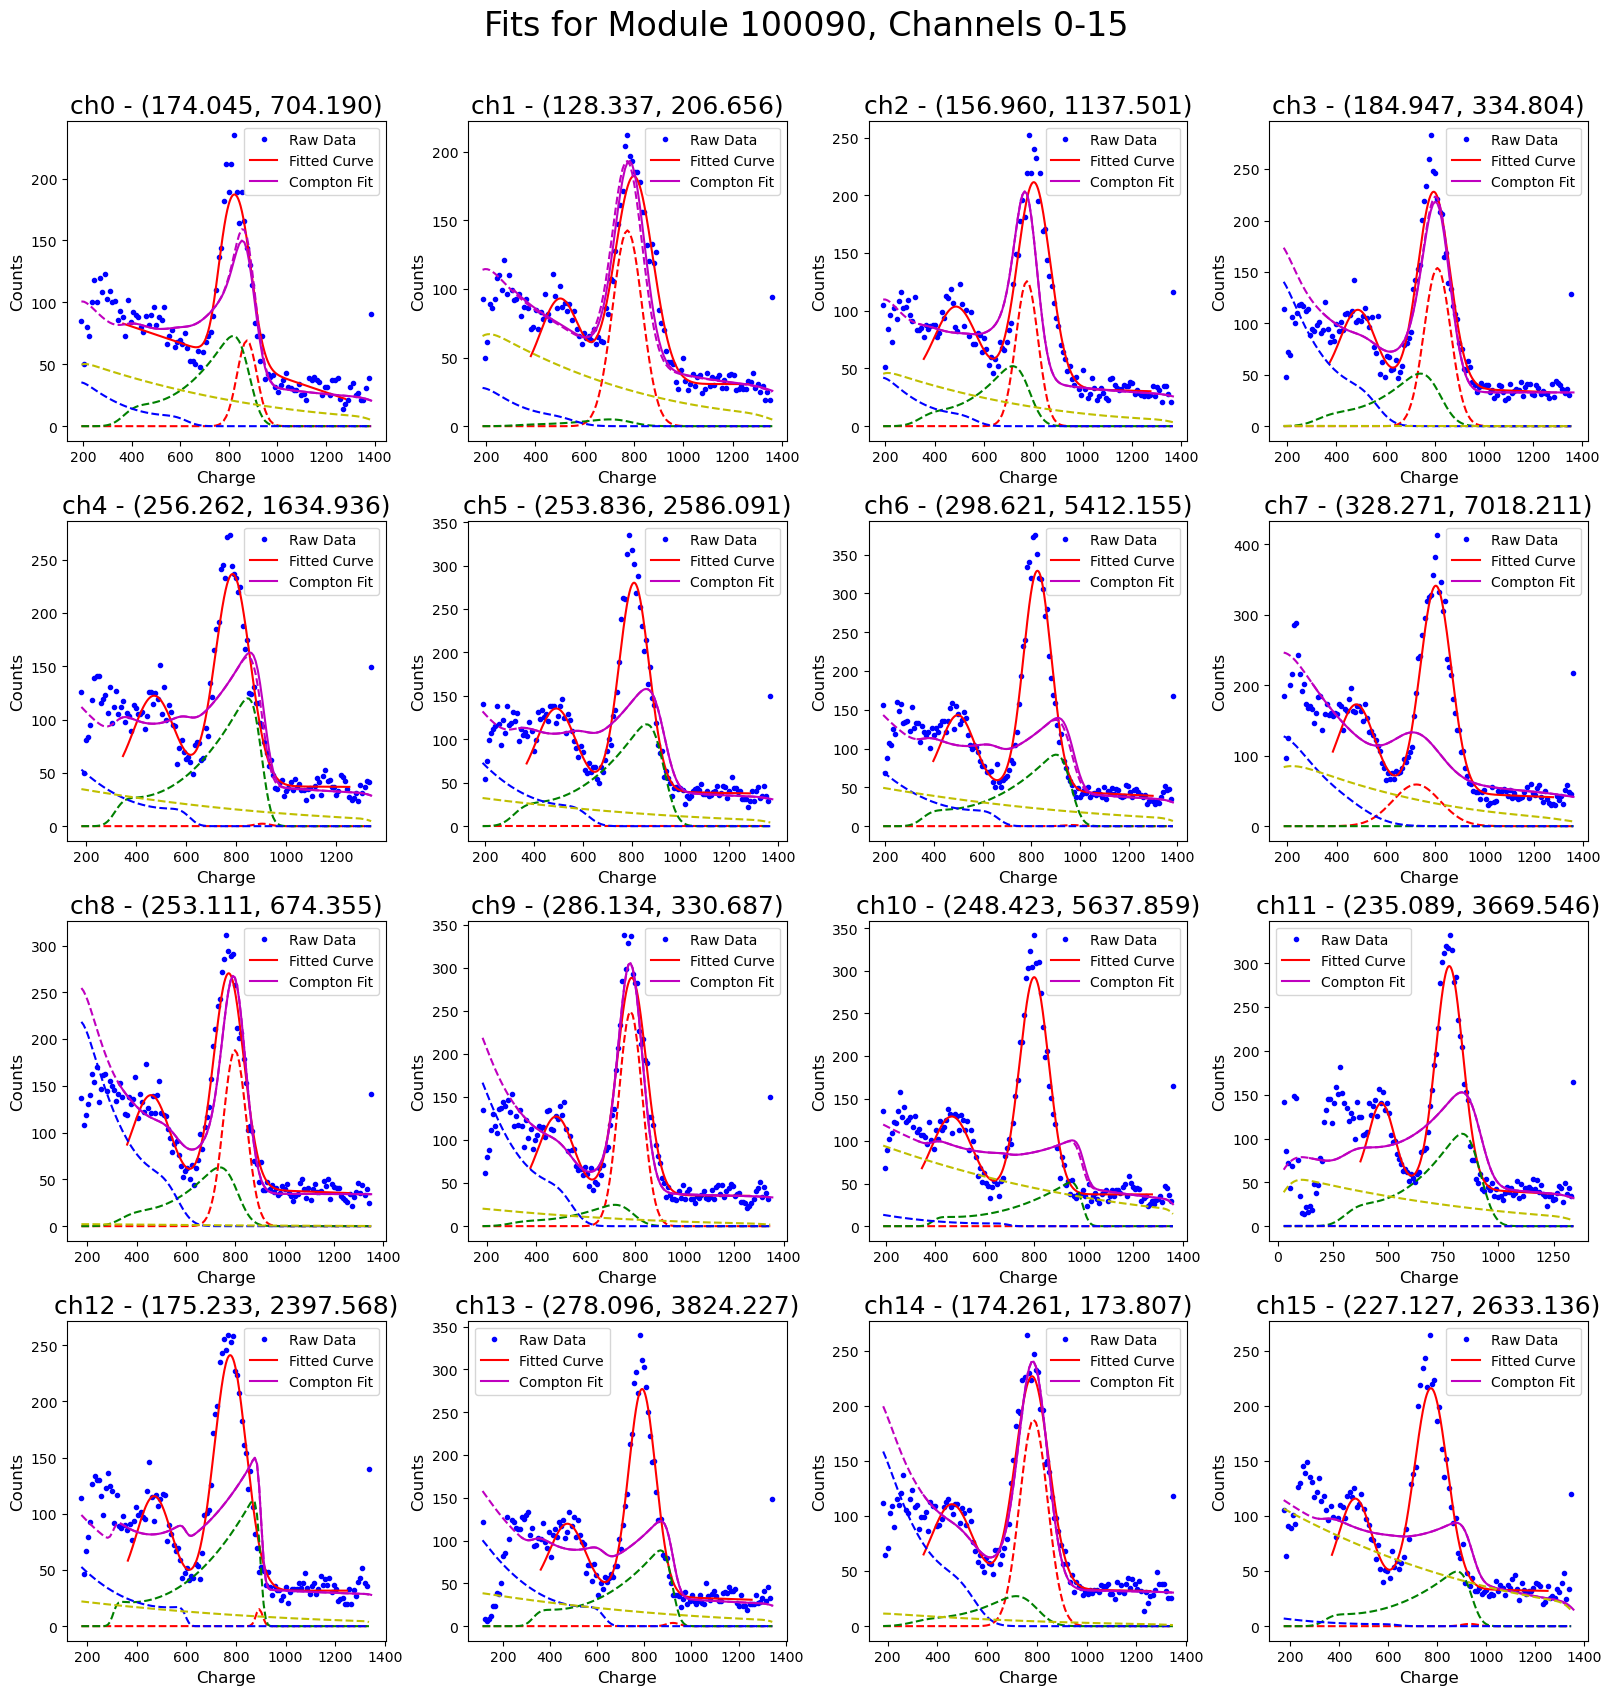

In [760]:
#file_path = "module_200040_Vov2.00_Nspe100000_Nsodium200000.root"
#file_path = "module_100025_Vov2.00_Nspe100000_Nsodium200000.root"
file_path = "module_100090_Vov3.00_Nspe10000_Nsodium100000.root"
row_num = 4; col_num = 4
#fig, ax = plt.subplots(row_num,col_num, figsize=(16, 16), constrained_layout=True)
fig, ax = plt.subplots(row_num,col_num, figsize=(16, 16), constrained_layout=True)
#plt.figure(figsize=(30, 30))
ch = 0

centers = []

plt.suptitle("Fits for Module 100090, Channels 0-15", fontsize=24, y=1.05)
for row in range(row_num):
    for col in range(col_num):
        x_original, y_original, x, y, x_fit, y_fit, param_tuple, chi2 = fit_modified(file_path, ch, "sodium")
        cx_original, cy_original, cx, cy, cx_fit, cy_fit, cparam_tuple, cchi2 = fit_compton(file_path, ch, "sodium")
        # print(cparam_tuple)
        ax[row, col].plot(x_original, y_original, "b.", label="Raw Data")
        # ax[row, col].plot(x, y, "g--", label="Smoothed Data")
        ax[row, col].plot(x_fit, y_fit, "r-", label="Fitted Curve")
        ax[row, col].plot(cx_fit, cy_fit, "m-", label="Compton Fit")
        ax[row, col].set_xlabel("Charge", fontsize=12)
        ax[row, col].set_ylabel("Counts", fontsize=12)
        ax[row, col].legend()
        ax[row, col].set_title(f"ch{ch} - ({chi2:.3f}, {cchi2:.3f})", fontsize=18)

        # centers.append([param_tuple[1], cparam_tuple[1]])
        centers.append([param_tuple[1], cparam_tuple[2]])

        # o, s, m1, a1, ac1, ae1, ae2, c = 0, *cparam_tuple
        o, s, m1, a1, ac1, ae1, ae2, c = cparam_tuple
        y_spectrum = full_spectrum(x_original, o, s, m1, a1, ac1, ae1, ae2, c)
        y_sg = full_spectrum(x_original, o, s, m1, a1, 0, 0, 0, 0)
        y_sc = full_spectrum(x_original, o, s, m1, 0, ac1, 0, 0, 0)
        y_se = full_spectrum(x_original, o, s, m1, 0, 0, ae1, 0, 0)
        y_se2 = full_spectrum(x_original, o, s, m1, 0, 0, 0, ae2, 0)
        # ax[row, col].plot(x_original, y_original, "k")
        ax[row, col].plot(x_original, y_spectrum, "m--")
        ax[row, col].plot(x_original, y_sg, "r--")
        ax[row, col].plot(x_original, y_sc, "g--")
        ax[row, col].plot(x_original, y_se, "b--")
        ax[row, col].plot(x_original, y_se2, "y--")


        # print(f"ch{ch:<2} | Chi2 = {chi2:>5.3f} ")
        '''
        function_str = (
            f"$y = {a1:.2f} e^{{-\\left(\\frac{{x - {m1:.2f}}}{{{s1:.2f}}}\\right)^2}}"
            f" + {a2:.2f} e^{{-\\left(\\frac{{x - {m2:.2f}}}{{{s2:.2f}}}\\right)^2}}"
            f" + {m:.2f} x + {c:.2f}$"
        )
          '''
        ch+=1
      
#
#plt.tight_layout()
#plt.subplots_adjust(top=0.95)
#fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig("fits_module100090_ch0-15_052924.png", dpi=100, bbox_inches='tight')
plt.show()



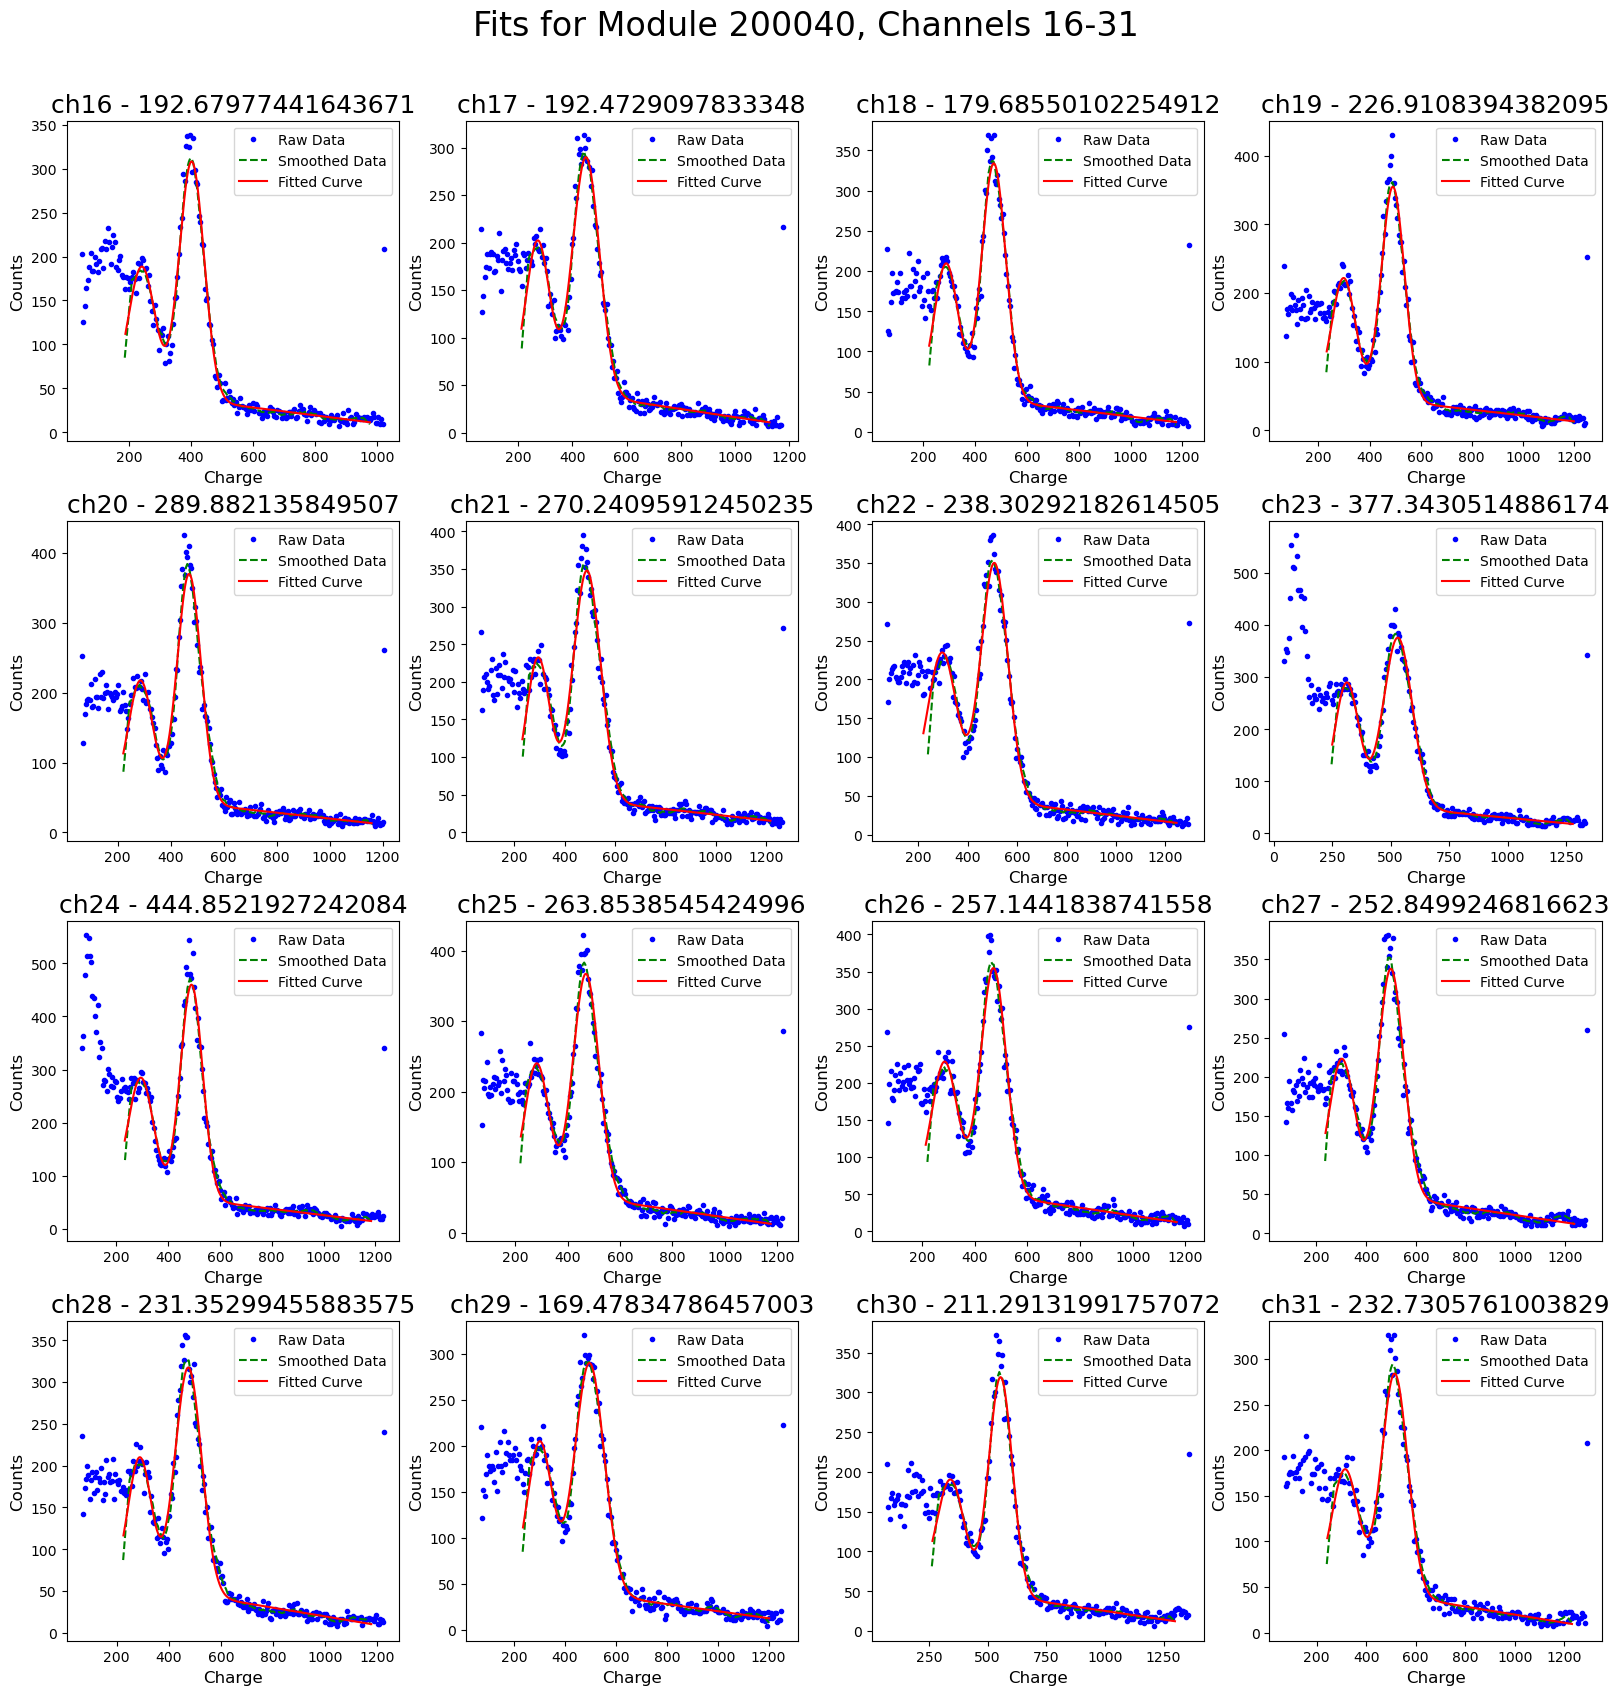

In [761]:
# file_path = "module_200040_Vov2.00_Nspe100000_Nsodium200000.root"
# #file_path = "module_100025_Vov2.00_Nspe100000_Nsodium200000.root"
# # file_path = "module_200060_Vov3.00_Nspe10000_Nsodium100000.root"
# row_num = 4; col_num = 4
# #fig, ax = plt.subplots(row_num,col_num, figsize=(16, 16), constrained_layout=True)
# fig, ax = plt.subplots(row_num,col_num, figsize=(16, 16), constrained_layout=True)
# #plt.figure(figsize=(30, 30))
# ch = 16

# plt.suptitle("Fits for Module 200040, Channels 16-31", fontsize=24, y=1.05)
# for row in range(row_num):
#     for col in range(col_num):
#         x_original, y_original, x, y, x_fit, y_fit, param_tuple, chi2 = fit_modified(file_path, ch, "sodium")
        
#         ax[row, col].plot(x_original, y_original, "b.", label="Raw Data")
#         ax[row, col].plot(x, y, "g", label="Smoothed Data", linestyle="--")
#         ax[row, col].plot(x_fit, y_fit, "r-", label="Fitted Curve")
#         ax[row, col].set_xlabel("Charge", fontsize=12)
#         ax[row, col].set_ylabel("Counts", fontsize=12)
#         ax[row, col].legend()
#         ax[row, col].set_title(f"ch{ch} - {chi2}", fontsize=18)
#         '''
#         function_str = (
#             f"$y = {a1:.2f} e^{{-\\left(\\frac{{x - {m1:.2f}}}{{{s1:.2f}}}\\right)^2}}"
#             f" + {a2:.2f} e^{{-\\left(\\frac{{x - {m2:.2f}}}{{{s2:.2f}}}\\right)^2}}"
#             f" + {m:.2f} x + {c:.2f}$"
#         )
#         '''
#         ch+=1
# #
# #plt.tight_layout()
# #plt.subplots_adjust(top=0.95)
# #fig.tight_layout(rect=[0, 0, 1, 0.98])
# plt.savefig("fits_module200060_ch16-31_052924.png", dpi=100, bbox_inches='tight')
# plt.show()



In [762]:
# file_path = "module_200040_Vov2.00_Nspe100000_Nsodium200000.root"
# #file_path = "module_100025_Vov2.00_Nspe100000_Nsodium200000.root"
# row_num = 4; col_num = 4
# #fig, ax = plt.subplots(row_num,col_num, figsize=(16, 16), constrained_layout=True)
# fig, ax = plt.subplots(row_num,col_num, figsize=(16, 16), constrained_layout=True)
# #plt.figure(figsize=(30, 30))
# ch = 16

# plt.suptitle("Fits for Module 200040, Channels 16-31", fontsize=24, y=1.05)
# for row in range(row_num):
#     for col in range(col_num):
#         x_original, y_original, x, y, x_fit, y_fit, param_tuple, chi2 = fit_modified(file_path, ch, "sodium")
        
#         ax[row, col].plot(x_original, y_original, "b.", label="Raw Data")
#         ax[row, col].plot(x, y, "g", label="Smoothed Data", linestyle="--")
#         ax[row, col].plot(x_fit, y_fit, "r-", label="Fitted Curve")
#         ax[row, col].set_xlabel("Charge", fontsize=12)
#         ax[row, col].set_ylabel("Counts", fontsize=12)
#         ax[row, col].legend()
#         ax[row, col].set_title(f"ch{ch} - {chi2}", fontsize=18)
#         '''
#         function_str = (
#             f"$y = {a1:.2f} e^{{-\\left(\\frac{{x - {m1:.2f}}}{{{s1:.2f}}}\\right)^2}}"
#             f" + {a2:.2f} e^{{-\\left(\\frac{{x - {m2:.2f}}}{{{s2:.2f}}}\\right)^2}}"
#             f" + {m:.2f} x + {c:.2f}$"
#         )
#         '''
#         ch+=1
# #
# #plt.tight_layout()
# #plt.subplots_adjust(top=0.95)
# #fig.tight_layout(rect=[0, 0, 1, 0.98])
# plt.savefig("fits_051424_module200040_ch16-31_052124_2_adjustLinear.png", dpi=100, bbox_inches='tight')
# plt.show()



In [763]:
# #file_path = "module_200040_Vov2.00_Nspe100000_Nsodium200000.root"
# file_path = "module_100025_Vov2.00_Nspe100000_Nsodium200000.root"
# row_num = 4; col_num = 4
# #fig, ax = plt.subplots(row_num,col_num, figsize=(16, 16), constrained_layout=True)
# fig, ax = plt.subplots(row_num,col_num, figsize=(16, 16), constrained_layout=True)
# #plt.figure(figsize=(30, 30))
# ch = 0

# plt.suptitle("Fits for Module 100025, Channels 0-15", fontsize=24, y=1.05)
# for row in range(row_num):
#     for col in range(col_num):
#         x_original, y_original, x, y, x_fit, y_fit, param_tuple, chi2 = fit_modified(file_path, ch, "sodium")
        
#         ax[row, col].plot(x_original, y_original, "b.", label="Raw Data")
#         ax[row, col].plot(x, y, "g", label="Smoothed Data", linestyle="--")
#         ax[row, col].plot(x_fit, y_fit, "r-", label="Fitted Curve")
#         ax[row, col].set_xlabel("Charge", fontsize=12)
#         ax[row, col].set_ylabel("Counts", fontsize=12)
#         ax[row, col].legend()
#         ax[row, col].set_title(f"ch{ch} - {chi2}", fontsize=18)
#         '''
#         function_str = (
#             f"$y = {a1:.2f} e^{{-\\left(\\frac{{x - {m1:.2f}}}{{{s1:.2f}}}\\right)^2}}"
#             f" + {a2:.2f} e^{{-\\left(\\frac{{x - {m2:.2f}}}{{{s2:.2f}}}\\right)^2}}"
#             f" + {m:.2f} x + {c:.2f}$"
#         )
#         '''
#         ch+=1
# #
# #plt.tight_layout()
# #plt.subplots_adjust(top=0.95)
# #fig.tight_layout(rect=[0, 0, 1, 0.98])
# plt.savefig("fits_051424_module100025_ch0-15_052124_2.png", dpi=100, bbox_inches='tight')
# plt.show()



In [764]:
# #file_path = "module_200040_Vov2.00_Nspe100000_Nsodium200000.root"
# file_path = "module_100090_Vov3.00_Nspe10000_Ncesium100000.root"
# row_num = 4; col_num = 4
# #fig, ax = plt.subplots(row_num,col_num, figsize=(16, 16), constrained_layout=True)
# fig, ax = plt.subplots(row_num,col_num, figsize=(16, 16), constrained_layout=True)
# #plt.figure(figsize=(30, 30))
# ch = 0

# plt.suptitle("Cesium Fits for Module 100090, Channels 0-15", fontsize=24, y=1.05)
# for row in range(row_num):
#     for col in range(col_num):
#         x_original, y_original, x, y, x_fit, y_fit, param_tuple, chi2 = fit_modified(file_path, ch, "cesium")
        
#         ax[row, col].plot(x_original, y_original, "b.", label="Raw Data")
#         ax[row, col].plot(x, y, "g", label="Smoothed Data", linestyle="--")
#         ax[row, col].plot(x_fit, y_fit, "r-", label="Fitted Curve")
#         ax[row, col].set_xlabel("Charge", fontsize=12)
#         ax[row, col].set_ylabel("Counts", fontsize=12)
#         ax[row, col].legend()
#         ax[row, col].set_title(f"ch{ch} - {chi2}", fontsize=18)
#         '''
#         function_str = (
#             f"$y = {a1:.2f} e^{{-\\left(\\frac{{x - {m1:.2f}}}{{{s1:.2f}}}\\right)^2}}"
#             f" + {a2:.2f} e^{{-\\left(\\frac{{x - {m2:.2f}}}{{{s2:.2f}}}\\right)^2}}"
#             f" + {m:.2f} x + {c:.2f}$"
#         )
#         '''
#         ch+=1
# #
# #plt.tight_layout()
# #plt.subplots_adjust(top=0.95)
# #fig.tight_layout(rect=[0, 0, 1, 0.98])
# plt.savefig("fits_module100090_cesium_ch0-15_052924.png", dpi=100, bbox_inches='tight')
# plt.show()



In [765]:
# #file_path = "module_200040_Vov2.00_Nspe100000_Nsodium200000.root"
# file_path = "module_200060_Vov3.00_Nspe10000_Ncesium100000.root"
# row_num = 4; col_num = 4
# #fig, ax = plt.subplots(row_num,col_num, figsize=(16, 16), constrained_layout=True)
# fig, ax = plt.subplots(row_num,col_num, figsize=(16, 16), constrained_layout=True)
# #plt.figure(figsize=(30, 30))
# ch = 0

# plt.suptitle("Cesium fits for Module 200060, Channels 0-15", fontsize=24, y=1.05)
# for row in range(row_num):
#     for col in range(col_num):
#         x_original, y_original, x, y, x_fit, y_fit, param_tuple, chi2 = fit_modified(file_path, ch, "cesium")
        
#         ax[row, col].plot(x_original, y_original, "b.", label="Raw Data")
#         ax[row, col].plot(x, y, "g", label="Smoothed Data", linestyle="--")
#         ax[row, col].plot(x_fit, y_fit, "r-", label="Fitted Curve")
#         ax[row, col].set_xlabel("Charge", fontsize=12)
#         ax[row, col].set_ylabel("Counts", fontsize=12)
#         ax[row, col].legend()
#         ax[row, col].set_title(f"ch{ch} - {chi2}", fontsize=18)
#         '''
#         function_str = (
#             f"$y = {a1:.2f} e^{{-\\left(\\frac{{x - {m1:.2f}}}{{{s1:.2f}}}\\right)^2}}"
#             f" + {a2:.2f} e^{{-\\left(\\frac{{x - {m2:.2f}}}{{{s2:.2f}}}\\right)^2}}"
#             f" + {m:.2f} x + {c:.2f}$"
#         )
#         '''
#         ch+=1
# #
# #plt.tight_layout()
# #plt.subplots_adjust(top=0.95)
# #fig.tight_layout(rect=[0, 0, 1, 0.98])
# plt.savefig("fits_module200060_cesium_ch0-15_052924.png", dpi=100, bbox_inches='tight')
# plt.show()

